In [1]:
#!pip install torch numpy matplotlib sacrebleu

In [2]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace

# we will use CUDA if it is available
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0') if USE_CUDA else torch.device('cpu') # set to 'cuda:0' if available
# print("CUDA:", USE_CUDA)
# print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

/home/shreessh/anaconda3/envs/hagrid/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class EncoderDecoder(nn.Module):
  """
  A standard Encoder-Decoder architecture. Base for this and many 
  other models.
  """
  def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
    super(EncoderDecoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.generator = generator
      
  def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
    """Take in and process masked src and target sequences."""
    encoder_hidden, encoder_final = self.encode(src, src_mask, src_lengths)
    return self.decode(encoder_hidden, encoder_final, src_mask, trg, trg_mask)
  
  def encode(self, src, src_mask, src_lengths):
    return self.encoder(self.src_embed(src), src_mask, src_lengths)
  
  def decode(self, encoder_hidden, encoder_final, src_mask, trg, trg_mask,
              decoder_hidden=None):
    return self.decoder(self.trg_embed(trg), encoder_hidden, encoder_final,
                        src_mask, trg_mask, hidden=decoder_hidden)

class Generator(nn.Module):
  """Define standard linear + softmax generation step."""
  def __init__(self, hidden_size, vocab_size):
    super(Generator, self).__init__()
    self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

class Encoder(nn.Module):
  """Encodes a sequence of word embeddings"""
  def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
    super(Encoder, self).__init__()
    self.num_layers = num_layers
    self.rnn = nn.GRU(input_size, hidden_size, num_layers, 
                      batch_first=True, bidirectional=True, dropout=dropout)
      
  def forward(self, x, mask, lengths):
    """
    Applies a bidirectional GRU to sequence of embeddings x.
    The input mini-batch x needs to be sorted by length.
    x should have dimensions [batch, time, dim].
    """
    packed = pack_padded_sequence(x, lengths, batch_first=True)
    output, final = self.rnn(packed)
    output, _ = pad_packed_sequence(output, batch_first=True)

    # we need to manually concatenate the final states for both directions
    fwd_final = final[0:final.size(0):2]
    bwd_final = final[1:final.size(0):2]
    final = torch.cat([fwd_final, bwd_final], dim=2)  # [num_layers, batch, 2*dim]

    return output, final

class Decoder(nn.Module):
  """A conditional RNN decoder with attention."""
  
  def __init__(self, emb_size, hidden_size, attention, num_layers=1, dropout=0.5,
                bridge=True):
    super(Decoder, self).__init__()
    
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.attention = attention
    self.dropout = dropout
              
    self.rnn = nn.GRU(emb_size + 2*hidden_size, hidden_size, num_layers,
                      batch_first=True, dropout=dropout)
              
    # to initialize from the final encoder state
    self.bridge = nn.Linear(2*hidden_size, hidden_size, bias=True) if bridge else None

    self.dropout_layer = nn.Dropout(p=dropout)
    self.pre_output_layer = nn.Linear(hidden_size + 2*hidden_size + emb_size,
                                      hidden_size, bias=False)
        
  def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key, hidden):
    """Perform a single decoder step (1 word)"""

    # compute context vector using attention mechanism
    query = hidden[-1].unsqueeze(1)  # [#layers, B, D] -> [B, 1, D]
    context, attn_probs = self.attention(
        query=query, proj_key=proj_key,
        value=encoder_hidden, mask=src_mask)

    # update rnn hidden state
    rnn_input = torch.cat([prev_embed, context], dim=2)
    output, hidden = self.rnn(rnn_input, hidden)
    
    pre_output = torch.cat([prev_embed, output, context], dim=2)
    pre_output = self.dropout_layer(pre_output)
    pre_output = self.pre_output_layer(pre_output)

    return output, hidden, pre_output
    
  def forward(self, trg_embed, encoder_hidden, encoder_final, 
              src_mask, trg_mask, hidden=None, max_len=None):
    """Unroll the decoder one step at a time."""
                                      
    # the maximum number of steps to unroll the RNN
    if max_len is None:
      print("max_len is None")
      max_len = trg_mask.size(-1)

    # initialize decoder hidden state
    if hidden is None:
      hidden = self.init_hidden(encoder_final)
    
    # pre-compute projected encoder hidden states
    # (the "keys" for the attention mechanism)
    # this is only done for efficiency
    proj_key = self.attention.key_layer(encoder_hidden)
    
    # here we store all intermediate hidden states and pre-output vectors
    decoder_states = []
    pre_output_vectors = []
    
    # unroll the decoder RNN for max_len steps
    for i in range(max_len):
      prev_embed = trg_embed[:, i].unsqueeze(1)
      output, hidden, pre_output = self.forward_step(
        prev_embed, encoder_hidden, src_mask, proj_key, hidden)
      decoder_states.append(output)
      pre_output_vectors.append(pre_output)

    decoder_states = torch.cat(decoder_states, dim=1)
    pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
    return decoder_states, hidden, pre_output_vectors  # [B, N, D]

  def init_hidden(self, encoder_final):
    """Returns the initial decoder state,
    conditioned on the final encoder state."""

    if encoder_final is None:
        return None  # start with zeros

    return torch.tanh(self.bridge(encoder_final))            

class BahdanauAttention(nn.Module):
  """Implements Bahdanau (MLP) attention"""
    
  def __init__(self, hidden_size, key_size=None, query_size=None):
    super(BahdanauAttention, self).__init__()
    
    # We assume a bi-directional encoder so key_size is 2*hidden_size
    key_size = 2 * hidden_size if key_size is None else key_size
    query_size = hidden_size if query_size is None else query_size

    self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
    self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
    self.energy_layer = nn.Linear(hidden_size, 1, bias=False)
    
    # to store attention scores
    self.alphas = None
        
  def forward(self, query=None, proj_key=None, value=None, mask=None):
    assert mask is not None, "mask is required"

    # We first project the query (the decoder state).
    # The projected keys (the encoder states) were already pre-computated.
    query = self.query_layer(query)
    
    # Calculate scores.
    scores = self.energy_layer(torch.tanh(query + proj_key))
    scores = scores.squeeze(2).unsqueeze(1)
    
    # Mask out invalid positions.
    # The mask marks valid positions so we invert it using `mask & 0`.
    scores.data.masked_fill_(mask == 0, -float('inf'))
    
    # Turn scores to probabilities.
    alphas = F.softmax(scores, dim=-1)
    self.alphas = alphas        
    
    # The context vector is the weighted sum of the values.
    context = torch.bmm(alphas, value)
    
    # context shape: [B, 1, 2D], alphas shape: [B, 1, M]
    return context, alphas

def make_model(src_vocab, tgt_vocab, emb_size=256, hidden_size=512, num_layers=1, dropout=0.1):
  "Helper: Construct a model from hyperparameters."

  attention = BahdanauAttention(hidden_size)

  model = EncoderDecoder(
      Encoder(emb_size, hidden_size, num_layers=num_layers, dropout=dropout),
      Decoder(emb_size, hidden_size, attention, num_layers=num_layers, dropout=dropout),
      nn.Embedding(src_vocab, emb_size),
      nn.Embedding(tgt_vocab, emb_size),
      Generator(hidden_size, tgt_vocab))

  return model.cuda() if USE_CUDA else model

In [4]:
class Batch:
  """Object for holding a batch of data with mask during training.
  Input is a batch from a torch text iterator.
  """
  def __init__(self, src, trg, pad_index=0):
      
    src, src_lengths = src
    
    self.src = src
    self.src_lengths = src_lengths
    self.src_mask = (src != pad_index).unsqueeze(-2)
    self.nseqs = src.size(0)
    
    self.trg = None
    self.trg_y = None
    self.trg_mask = None
    self.trg_lengths = None
    self.ntokens = None

    if trg is not None:
      trg, trg_lengths = trg
      self.trg = trg[:, :-1]
      self.trg_lengths = trg_lengths
      self.trg_y = trg[:, 1:]
      self.trg_mask = (self.trg_y != pad_index)
      self.ntokens = (self.trg_y != pad_index).data.sum().item()
    
    if USE_CUDA:
      self.src = self.src.cuda()
      self.src_mask = self.src_mask.cuda()

      if trg is not None:
        self.trg = self.trg.cuda()
        self.trg_y = self.trg_y.cuda()
        self.trg_mask = self.trg_mask.cuda()

class SimpleLossCompute:
  """A simple loss compute and train function."""

  def __init__(self, generator, criterion, opt=None):
    self.generator = generator
    self.criterion = criterion
    self.opt = opt

  def __call__(self, x, y, norm):
    x = self.generator(x)
    loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                          y.contiguous().view(-1))
    loss = loss / norm

    if self.opt is not None:
      loss.backward()          
      self.opt.step()
      self.opt.zero_grad()

    return loss.data.item() * norm


def run_epoch(data_iter, model, loss_compute, print_every=50):
  """Standard Training and Logging Function"""

  start = time.time()
  total_tokens = 0
  total_loss = 0
  print_tokens = 0

  for i, batch in enumerate(data_iter, 1):
      
    out, _, pre_output = model.forward(batch.src, batch.trg,
                                        batch.src_mask, batch.trg_mask,
                                        batch.src_lengths, batch.trg_lengths)
    loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
    total_loss += loss
    total_tokens += batch.ntokens
    print_tokens += batch.ntokens
    
    if model.training and i % print_every == 0:
      elapsed = time.time() - start
      print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
              (i, loss / batch.nseqs, print_tokens / elapsed))
      start = time.time()
      print_tokens = 0

  return math.exp(total_loss / float(total_tokens))

def data_gen(num_words=11, batch_size=16, num_batches=100, length=10, pad_index=0, sos_index=1):
  """Generate random data for a src-tgt copy task."""
  for i in range(num_batches):
    data = torch.from_numpy(
      np.random.randint(1, num_words, size=(batch_size, length)))
    data[:, 0] = sos_index
    data = data.cuda() if USE_CUDA else data
    src = data[:, 1:]
    trg = data
    src_lengths = [length-1] * batch_size
    trg_lengths = [length] * batch_size
    yield Batch((src, src_lengths), (trg, trg_lengths), pad_index=pad_index)



In [66]:
seed = 56
np.random.seed(seed)
torch.manual_seed(seed)
num_words=10
data = list(data_gen(num_words=num_words, batch_size=3, num_batches=1, length=5))[0]

print(data.src)
print(data.src_mask.shape)
model = make_model(num_words, num_words, emb_size=32, hidden_size=64, dropout=0.0)
model.eval()
out, _, pre_output = model.forward(data.src, data.trg,
                                  data.src_mask, data.trg_mask,
                                  data.src_lengths, data.trg_lengths)
print(out.shape, pre_output.shape)

tensor([[5, 1, 3, 8],
        [5, 8, 2, 9],
        [1, 6, 7, 2]])
torch.Size([3, 1, 4])
torch.Size([3, 4, 64]) torch.Size([3, 4, 64])


In [5]:
def greedy_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None):
  """Greedily decode a sentence."""

  with torch.no_grad():
    encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
    prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
    trg_mask = torch.ones_like(prev_y)

  output = []
  attention_scores = []
  hidden = None

  for i in range(max_len):
    with torch.no_grad():
      out, hidden, pre_output = model.decode(
        encoder_hidden, encoder_final, src_mask,
        prev_y, trg_mask, hidden)

      # we predict from the pre-output layer, which is
      # a combination of Decoder state, prev emb, and context
      prob = model.generator(pre_output[:, -1])

    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.data.item()
    output.append(next_word)
    prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
    attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
  
  output = np.array(output)
        
  # cut off everything starting from </s> 
  # (only when eos_index provided)
  if eos_index is not None:
    first_eos = np.where(output==eos_index)[0]
    if len(first_eos) > 0:
      output = output[:first_eos[0]]      
  
  return output, np.concatenate(attention_scores, axis=1)


def lookup_words(x, vocab=None):
  if vocab is not None:
    x = [vocab.itos[i] for i in x]

  return [str(t) for t in x]


def print_examples(example_iter, model, n=2, max_len=100, 
                   sos_index=1, 
                   src_eos_index=None, 
                   trg_eos_index=None, 
                   src_vocab=None, trg_vocab=None):
  """Prints N examples. Assumes batch size of 1."""

  model.eval()
  count = 0
  print()
  
  if src_vocab is not None and trg_vocab is not None:
    src_eos_index = src_vocab.stoi[EOS_TOKEN]
    trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
    trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
  else:
    src_eos_index = None
    trg_sos_index = 1
    trg_eos_index = None
        
  for i, batch in enumerate(example_iter):
    
    src = batch.src.cpu().numpy()[0, :]
    trg = batch.trg_y.cpu().numpy()[0, :]

    # remove </s> (if it is there)
    src = src[:-1] if src[-1] == src_eos_index else src
    trg = trg[:-1] if trg[-1] == trg_eos_index else trg      
  
    result, _ = greedy_decode(
      model, batch.src, batch.src_mask, batch.src_lengths,
      max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)
    print("Example #%d" % (i+1))
    print("Src : ", " ".join(lookup_words(src, vocab=src_vocab)))
    print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
    print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
    print()
    
    count += 1
    if count == n:
        break


def train_copy_task():
  """Train the simple copy task."""
  num_words = 11
  criterion = nn.NLLLoss(reduction="sum", ignore_index=0)
  model = make_model(num_words, num_words, emb_size=32, hidden_size=64)
  optim = torch.optim.Adam(model.parameters(), lr=0.0003)
  eval_data = list(data_gen(num_words=num_words, batch_size=1, num_batches=1))

  dev_perplexities = []
  
  if USE_CUDA:
    model.cuda()

  for epoch in range(1):
    
    print("Epoch %d" % epoch)

    # train
    model.train()
    data = data_gen(num_words=num_words, batch_size=32, num_batches=1)
    print("train step")
    run_epoch(data, model,
              SimpleLossCompute(model.generator, criterion, optim))

    # evaluate
    model.eval()
    with torch.no_grad():
      print("test step")
      perplexity = run_epoch(eval_data, model,
                              SimpleLossCompute(model.generator, criterion, None))
      print("Evaluation perplexity: %f" % perplexity)
      dev_perplexities.append(perplexity)
      print_examples(eval_data, model, n=2, max_len=9)
      
  return dev_perplexities



In [6]:
# train the copy task
dev_perplexities = train_copy_task()

# def plot_perplexity(perplexities):
#   """plot perplexities"""
#   plt.title("Perplexity per Epoch")
#   plt.xlabel("Epoch")
#   plt.ylabel("Perplexity")
#   plt.plot(perplexities)
    
# plot_perplexity(dev_perplexities)

Epoch 0
train step
max_len is None
test step
max_len is None
Evaluation perplexity: 11.657849

max_len is None
max_len is None
max_len is None
max_len is None
max_len is None
max_len is None
max_len is None
max_len is None
max_len is None
Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  3 0 6 0 8 6 0 8 6



/home/shreessh/anaconda3/envs/hagrid/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


You can see that the model managed to correctly 'translate' the two examples in the end.

Moreover, the perplexity of the development data nicely went down towards 1.

In [17]:
#!pip install git+git://github.com/pytorch/text spacy 
#!python -m spacy download en
#!python -m spacy download de

In [18]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    UNK_TOKEN = "<unk>"
    PAD_TOKEN = "<pad>"    
    SOS_TOKEN = "<s>"
    EOS_TOKEN = "</s>"
    LOWER = True
    
    # we include lengths to provide to the RNNs
    SRC = data.Field(tokenize=tokenize_de, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)
    TRG = data.Field(tokenize=tokenize_en, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)

    MAX_LEN = 25  # NOTE: we filter out a lot of sentences for speed
    train_data, valid_data, test_data = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TRG), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 5  # NOTE: we limit the vocabulary to frequent words for speed
    SRC.build_vocab(train_data.src, min_freq=MIN_FREQ)
    TRG.build_vocab(train_data.trg, min_freq=MIN_FREQ)
    
    PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]


In [19]:
def print_data_info(train_data, valid_data, test_data, src_field, trg_field):
    """ This prints some useful stuff about our data sets. """

    print("Data set sizes (number of sentence pairs):")
    print('train', len(train_data))
    print('valid', len(valid_data))
    print('test', len(test_data), "\n")

    print("First training example:")
    print("src:", " ".join(vars(train_data[0])['src']))
    print("trg:", " ".join(vars(train_data[0])['trg']), "\n")

    print("Most common words (src):")
    print("\n".join(["%10s %10d" % x for x in src_field.vocab.freqs.most_common(10)]), "\n")
    print("Most common words (trg):")
    print("\n".join(["%10s %10d" % x for x in trg_field.vocab.freqs.most_common(10)]), "\n")

    print("First 10 words (src):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(src_field.vocab.itos[:10])), "\n")
    print("First 10 words (trg):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(trg_field.vocab.itos[:10])), "\n")

    print("Number of German words (types):", len(src_field.vocab))
    print("Number of English words (types):", len(trg_field.vocab), "\n")
    
    
print_data_info(train_data, valid_data, test_data, SRC, TRG)

Data set sizes (number of sentence pairs):
train 143116
valid 690
test 963 

First training example:
src: david gallo : das ist bill lange . ich bin dave gallo .
trg: david gallo : this is bill lange . i 'm dave gallo . 

Most common words (src):
         .     138325
         ,     105944
       und      41839
       die      40809
       das      33324
       sie      33035
       ich      31153
       ist      31035
        es      27449
       wir      25817 

Most common words (trg):
         .     137259
         ,      91619
       the      73344
       and      50273
        to      42798
         a      39573
        of      39496
         i      33524
        it      32921
      that      32643 

First 10 words (src):
00 <unk>
01 <pad>
02 </s>
03 .
04 ,
05 und
06 die
07 das
08 sie
09 ich 

First 10 words (trg):
00 <unk>
01 <pad>
02 <s>
03 </s>
04 .
05 ,
06 the
07 and
08 to
09 a 

Number of German words (types): 15761
Number of English words (types): 13003 



In [20]:
train_iter = data.BucketIterator(train_data, batch_size=64, train=True, 
                                 sort_within_batch=True, 
                                 sort_key=lambda x: (len(x.src), len(x.trg)), repeat=False,
                                 device=DEVICE)
valid_iter = data.Iterator(valid_data, batch_size=1, train=False, sort=False, repeat=False, 
                           device=DEVICE)


def rebatch(pad_idx, batch):
    """Wrap torchtext batch into our own Batch class for pre-processing"""
    return Batch(batch.src, batch.trg, pad_idx)

## Training the System

Now we train the model. 

On a Titan X GPU, this runs at ~18,000 tokens per second with a batch size of 64.

In [21]:
def train(model, num_epochs=10, lr=0.0003, print_every=100):
    """Train a model on IWSLT"""
    
    if USE_CUDA:
        model.cuda()

    # optionally add label smoothing; see the Annotated Transformer
    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    dev_perplexities = []

    for epoch in range(num_epochs):
      
        print("Epoch", epoch)
        model.train()
        train_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in train_iter), 
                                     model,
                                     SimpleLossCompute(model.generator, criterion, optim),
                                     print_every=print_every)
        
        model.eval()
        with torch.no_grad():
            print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
                           model, n=3, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)        

            dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter), 
                                       model, 
                                       SimpleLossCompute(model.generator, criterion, None))
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)
        
    return dev_perplexities
        

In [22]:
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=1, dropout=0.2)
dev_perplexities = train(model, print_every=100)

Epoch 0


/home/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch Step: 100 Loss: 22.353386 Tokens per Sec: 16007.731248
Epoch Step: 200 Loss: 34.410126 Tokens per Sec: 16368.906298
Epoch Step: 300 Loss: 44.763870 Tokens per Sec: 16586.324787
Epoch Step: 400 Loss: 57.584606 Tokens per Sec: 16717.486756
Epoch Step: 500 Loss: 40.508701 Tokens per Sec: 16486.886104
Epoch Step: 600 Loss: 51.919121 Tokens per Sec: 16529.862635
Epoch Step: 700 Loss: 82.279633 Tokens per Sec: 16973.462052
Epoch Step: 800 Loss: 35.026432 Tokens per Sec: 16724.939524
Epoch Step: 900 Loss: 63.407204 Tokens per Sec: 16606.524355
Epoch Step: 1000 Loss: 37.909828 Tokens per Sec: 19105.497130
Epoch Step: 1100 Loss: 90.584244 Tokens per Sec: 19643.264684
Epoch Step: 1200 Loss: 84.000832 Tokens per Sec: 19468.084935
Epoch Step: 1300 Loss: 54.331242 Tokens per Sec: 19679.282614
Epoch Step: 1400 Loss: 49.921040 Tokens per Sec: 19629.820942
Epoch Step: 1500 Loss: 21.851797 Tokens per Sec: 19565.639729
Epoch Step: 1600 Loss: 55.154270 Tokens per Sec: 19515.738007
Epoch Step: 1700 

Example #2
Src :  mein vater hörte sich auf seinem kleinen , grauen radio die <unk> der bbc an .
Trg :  my father was listening to bbc news on his small , gray radio .
Pred:  my father was on his little , <unk> , <unk> , the <unk> of the bbc .

Example #3
Src :  er sah sehr glücklich aus , was damals ziemlich ungewöhnlich war , da ihn die nachrichten meistens <unk> .
Trg :  there was a big smile on his face which was unusual then , because the news mostly depressed him .
Pred:  he saw very happy , what was pretty much , because it was the <unk> .

Validation perplexity: 13.563748
Epoch 4
Epoch Step: 100 Loss: 9.601490 Tokens per Sec: 16309.901017
Epoch Step: 200 Loss: 13.329712 Tokens per Sec: 16693.352689
Epoch Step: 300 Loss: 61.213333 Tokens per Sec: 16774.275779
Epoch Step: 400 Loss: 37.759483 Tokens per Sec: 16628.037095
Epoch Step: 500 Loss: 35.616104 Tokens per Sec: 16677.874896
Epoch Step: 600 Loss: 58.753849 Tokens per Sec: 16452.736708
Epoch Step: 700 Loss: 11.741160 Tokens p

Epoch Step: 1600 Loss: 22.061657 Tokens per Sec: 18889.519602
Epoch Step: 1700 Loss: 11.148299 Tokens per Sec: 19179.133196
Epoch Step: 1800 Loss: 16.580446 Tokens per Sec: 19184.709044
Epoch Step: 1900 Loss: 20.219671 Tokens per Sec: 18889.205997
Epoch Step: 2000 Loss: 21.245464 Tokens per Sec: 18869.151894
Epoch Step: 2100 Loss: 29.567142 Tokens per Sec: 18825.496347
Epoch Step: 2200 Loss: 22.790722 Tokens per Sec: 18923.950021

Example #1
Src :  als ich 11 jahre alt war , wurde ich eines morgens von den <unk> heller freude geweckt .
Trg :  when i was 11 , i remember waking up one morning to the sound of joy in my house .
Pred:  when i was 11 years old , i was <unk> a <unk> of the <unk> <unk> joy .

Example #2
Src :  mein vater hörte sich auf seinem kleinen , grauen radio die <unk> der bbc an .
Trg :  my father was listening to bbc news on his small , gray radio .
Pred:  my father listened to his little , <unk> radio <unk> the <unk> of the bbc .

Example #3
Src :  er sah sehr glückli

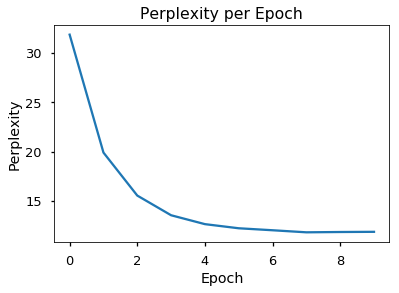

In [23]:
plot_perplexity(dev_perplexities)

In [24]:
import sacrebleu

In [25]:
# this should result in a perfect BLEU of 100%
hypotheses = ["this is a test"]
references = ["this is a test"]
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

100.00000000000004


In [26]:
# here the BLEU score will be lower, because some n-grams won't match
hypotheses = ["this is a test"]
references = ["this is a fest"]
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

22.360679774997894


Since we did some filtering for speed, our validation set contains 690 sentences.
The references are the tokenized versions, but they should not contain out-of-vocabulary UNKs that our network might have seen. So we'll take the references straight out of the `valid_data` object:

In [27]:
len(valid_data)

690

In [28]:
references = [" ".join(example.trg) for example in valid_data]
print(len(references))
print(references[0])

690
when i was 11 , i remember waking up one morning to the sound of joy in my house .


In [29]:
references[-2]

"i 'm always the one taking the picture ."

**Now we translate the validation set!**

This might take a little bit of time.

Note that `greedy_decode` will cut-off the sentence when it encounters the end-of-sequence symbol, if we provide it the index of that symbol.

In [30]:
hypotheses = []
alphas = []  # save the last attention scores
for batch in valid_iter:
  batch = rebatch(PAD_INDEX, batch)
  pred, attention = greedy_decode(
    model, batch.src, batch.src_mask, batch.src_lengths, max_len=25,
    sos_index=TRG.vocab.stoi[SOS_TOKEN],
    eos_index=TRG.vocab.stoi[EOS_TOKEN])
  hypotheses.append(pred)
  alphas.append(attention)

In [31]:
# we will still need to convert the indices to actual words!
hypotheses[0]

array([  70,   11,   24, 1460,    5,   11,   24,    9,    0,   10,    0,
          0, 1806,    4])

In [32]:
hypotheses = [lookup_words(x, TRG.vocab) for x in hypotheses]
hypotheses[0]

['when',
 'i',
 'was',
 '11',
 ',',
 'i',
 'was',
 'a',
 '<unk>',
 'of',
 '<unk>',
 '<unk>',
 'joy',
 '.']

In [33]:
# finally, the SacreBLEU raw scorer requires string input, so we convert the lists to strings
hypotheses = [" ".join(x) for x in hypotheses]
print(len(hypotheses))
print(hypotheses[0])

690
when i was 11 , i was a <unk> of <unk> <unk> joy .


In [34]:
# now we can compute the BLEU score!
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

23.4681520210298


## Attention Visualization

We can also visualize the attention scores of the decoder.

In [47]:
def plot_heatmap(src, trg, scores):

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='viridis')

    ax.set_xticklabels(trg, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

src ['"', 'jetzt', 'kannst', 'du', 'auf', 'eine', 'richtige', 'schule', 'gehen', ',', '"', 'sagte', 'er', '.', '</s>']
ref ['"', 'you', 'can', 'go', 'to', 'a', 'real', 'school', 'now', ',', '"', 'he', 'said', '.', '</s>']
pred ['"', 'now', 'you', 'can', 'go', 'to', 'a', 'right', 'school', ',', '"', 'he', 'said', '.', '</s>']


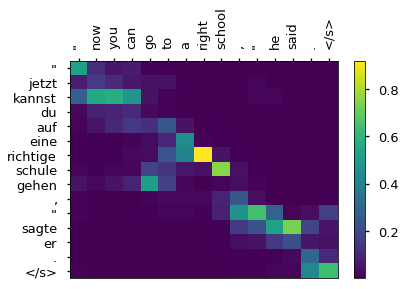

In [71]:
# This plots a chosen sentence, for which we saved the attention scores above.
idx = 5
src = valid_data[idx].src + ["</s>"]
trg = valid_data[idx].trg + ["</s>"]
pred = hypotheses[idx].split() + ["</s>"]
pred_att = alphas[idx][0].T[:, :len(pred)]
print("src", src)
print("ref", trg)
print("pred", pred)
plot_heatmap(src, pred, pred_att)

# Congratulations! You've finished this notebook.

What didn't we cover?

- Subwords / Byte Pair Encoding [[paper]](https://arxiv.org/abs/1508.07909) [[github]](https://github.com/rsennrich/subword-nmt) let you deal with unknown words. 
- You can implement a [multiplicative/bilinear attention mechanism](https://arxiv.org/abs/1508.04025) instead of the additive one used here.
- We used greedy decoding here to get translations, but you can get better results with beam search.
- The original model only uses a single dropout layer (in the decoder), but you can experiment with adding more dropout layers, for example on the word embeddings and the source word representations.
- You can experiment with multiple encoder/decoder layers.
- Experiment with a benchmarked and improved codebase: [Joey NMT](https://github.com/joeynmt/joeynmt)

If this was useful to your research, please consider citing:

> J Bastings. 2018. The Annotated Encoder-Decoder with Attention. https://bastings.github.io/annotated_encoder_decoder/

Or use the following `Bibtex`:
```
@misc{bastings2018annotated,
  title={The Annotated Encoder-Decoder with Attention},
  author={Bastings, J.},
  journal={https://bastings.github.io/annotated\_encoder\_decoder/},
  year={2018}
}```